In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, classification_report,mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('/Users/clara/Desktop/neuefische/d-drivers/data/data_features.csv')

In [3]:
df.drop(['page_id','url','video_play', 'page_impressions', 'clickouts','last_author','date_scraped','scraped_word_count','meta_title', 'meta_description',
         'abstract','meta_image_url','page_img_size', 'merged_url','last_publish_date', 'page_name', 'title','h1'], axis=1, inplace= True)
df['publish_date_min'] = pd.to_datetime(df['publish_date_min'])

df.dropna(axis=0, how='any', inplace=True)

In [4]:
# Filter columns of a specific data type (e.g., numerical columns)
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Filter columns of a specific data type (e.g., categorical columns)
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Filter columns of a specific data type (e.g., datetime columns)
datetime_columns = df.select_dtypes(include=['datetime']).columns.tolist()

# Combine numerical and categorical features
df_feat = df[numeric_columns + categorical_columns]
df_feat.drop(['external_clicks','external_impressions','ctr'],axis=1,inplace=True)

# One-hot encode all categorical features
df_enc = pd.get_dummies(df_feat, columns=categorical_columns, drop_first=True)

/var/folders/5s/w7hst37d0tv0r4hby2_mqqp00000gn/T/ipykernel_43053/1667737710.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat.drop(['external_clicks','external_impressions','ctr'],axis=1,inplace=True)


In [45]:
def lin_reg_evaluation(X, y, test_size=0.3, random_state=25):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit the linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Predictions on training and testing sets
    y_pred_train = lin_reg.predict(X_train)
    y_pred_test = lin_reg.predict(X_test)

    # Evaluation metrics
    print("R-squared (Train):", r2_score(y_train, y_pred_train).round(3))
    print("R-squared (Test):", r2_score(y_test, y_pred_test).round(3))
    #print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_test).round(3))
    #print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_test).round(3))
    #print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred_test)).round(3))
    
    # Get coefficients
    coefficients = lin_reg.coef_

    # Get absolute coefficients and corresponding feature names
    abs_coefficients = abs(coefficients)
    feature_names = [f"Feature_{i}" for i in range(len(abs_coefficients))]

    # Filter significant features (with non-zero coefficients)
    significant_features = [(name, coef) for name, coef in zip(feature_names, abs_coefficients) if coef != 0]

    # Display significant features and their importance
    for name, coef in significant_features:
        print(f'Feature: {name}, Score: {coef:.5f}')

    # Plot feature importance
    pyplot.bar([name for name, _ in significant_features], [coef for _, coef in significant_features])
    pyplot.xlabel('Features')
    pyplot.ylabel('Absolute Coefficients')
    pyplot.title('Significant Features and their Importance')
    pyplot.xticks(rotation=45)
    pyplot.show()


In [6]:
author_col = df_enc.filter(regex='author', axis=1)
media_col = df_enc.filter(regex='media', axis=1)
product_col = df_enc.filter(regex='classification_product', axis=1)
type_col = df_enc.filter(regex='classification_type', axis=1)

In [7]:
target = ['external_impressions', 'external_clicks', 'ctr']

columns = ['no_versions','n_days','classification_product','classification_type','scraped_author',
           'likes_n_days','dislikes_n_days','scraped_word_count','media_type','meta_title_len','meta_desc_len','h1_len','abstract_len']

X = {"Length related features" : "df[['word_count','meta_title_len', 'meta_desc_len', 'h1_len', 'abstract_len']]",
    "All features": "df_enc",
    "Performance metrics" : "df_enc[['likes_n_days','dislikes_n_days']]",
    "EDA identified features": "pd.concat([media_col, author_col, product_col, df_enc[['n_days','no_versions']]], axis=1)"
    }

for key, value in X.items():
    print(f"================ {key} ================")
    features = eval(value) 
    for item in target:
        y = df[item]
        print(f"Evaluating for target: {item}")
        lin_reg_evaluation(features, y)
        print()

================ Length related features ================
Evaluating for target: external_impressions
R-squared (Train): 0.008
R-squared (Test): -0.005
Mean Absolute Error (MAE): 778009.374
Mean Squared Error (MSE): 5653082706731.252
Root Mean Squared Error (RMSE): 2377621.229

Evaluating for target: external_clicks
R-squared (Train): 0.007
R-squared (Test): -0.007
Mean Absolute Error (MAE): 69077.728
Mean Squared Error (MSE): 46551377644.375
Root Mean Squared Error (RMSE): 215757.683

Evaluating for target: ctr
R-squared (Train): 0.029
R-squared (Test): 0.034
Mean Absolute Error (MAE): 2.75
Mean Squared Error (MSE): 14.777
Root Mean Squared Error (RMSE): 3.844

================ All features ================
Evaluating for target: external_impressions
R-squared (Train): 0.283
R-squared (Test): 0.459
Mean Absolute Error (MAE): 718426.674
Mean Squared Error (MSE): 3045168288364.155
Root Mean Squared Error (RMSE): 1745041.056

Evaluating for target: external_clicks
R-squared (Train): 0.27

In [8]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 20)
df_group = df[['no_versions',
 'n_days',
 #'classification_product',
 'classification_type',
 #'scraped_author',
 'likes_n_days',
 'dislikes_n_days',
 #'media_type',
 'meta_title_len',
 'meta_desc_len',
 'h1_len',
 'abstract_len',
 'external_impressions','external_clicks','ctr']].groupby(by="classification_type").median()
df_group

,no_versions,n_days,likes_n_days,dislikes_n_days,meta_title_len,meta_desc_len,h1_len,abstract_len,external_impressions,external_clicks,ctr
classification_type,,,,,,,,,,,
Deal,2.0,22.0,0.0,0.0,71.0,153.0,74.0,279.0,204123.0,13799.0,6.820575
Erfahrungsbericht,1.0,9.0,1.0,0.0,74.0,153.0,74.0,269.5,128107.5,8574.5,6.859064
Kaufberatung,1.0,13.0,0.0,0.0,69.0,152.0,70.5,283.5,60100.5,3567.5,5.886560
News,0.0,9.0,0.0,0.0,72.0,153.0,72.0,255.0,75717.0,5639.0,7.423454
Ratgeber,0.0,9.0,0.0,0.0,68.0,152.0,70.0,275.0,81488.0,4583.0,6.505418
Test,1.0,12.0,1.0,0.0,67.0,154.0,72.5,279.5,52972.5,3837.0,7.044687
Video,0.0,9.0,0.0,0.0,62.0,153.0,76.0,287.0,23346.0,1588.0,6.802022


### Classification Type

In [9]:
df_news = df.query("classification_type == 'News'")

R-squared (Train): 0.255
R-squared (Test): 0.173

In [10]:
df_news = df.query("classification_type == 'Ratgeber'")

R-squared (Train): 0.505
R-squared (Test): 0.366

In [11]:
df_news = df.query("classification_type == 'Kaufberatung'")

R-squared (Train): 0.832
R-squared (Test): -0.253^

In [12]:
df_news = df.query("classification_type == 'Deal'")

R-squared (Train): 0.687
R-squared (Test): 0.267

In [13]:
df_news = df.query("classification_type == 'Test'")

R-squared (Train): 1.0
R-squared (Test): -5.307

In [14]:
df_news = df.query("classification_type == 'Erfahrungsbericht'")

R-squared (Train): 0.295
R-squared (Test): -1.895

In [31]:
df_news = df.query("classification_type == 'Ratgeber'")

R-squared (Train): 1.0
R-squared (Test): nan

In [32]:
def encode_features(df):
    # Filter columns of a specific data type (e.g., numerical columns)
    numeric_columns = df_news.select_dtypes(include=['number']).columns.tolist()

    # Filter columns of a specific data type (e.g., categorical columns)
    categorical_columns = df_news.select_dtypes(include=['object', 'category']).columns.tolist()

    # Filter columns of a specific data type (e.g., datetime columns)
    datetime_columns = df_news.select_dtypes(include=['datetime']).columns.tolist()

    # Combine numerical and categorical features
    df_feat = df_news[numeric_columns + categorical_columns]
    df_feat.drop(['external_clicks','external_impressions','ctr'],axis=1,inplace=True)

    # One-hot encode all categorical features
    df_enc = pd.get_dummies(df_feat, columns=categorical_columns, drop_first=True)
    
    return df_enc

In [33]:
df_enc = encode_features(df_news)

author_col = df_enc.filter(regex='author', axis=1)
media_col = df_enc.filter(regex='media', axis=1)
product_col = df_enc.filter(regex='classification_product', axis=1)
type_col = df_enc.filter(regex='classification_type', axis=1)

/var/folders/5s/w7hst37d0tv0r4hby2_mqqp00000gn/T/ipykernel_43053/3957536942.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat.drop(['external_clicks','external_impressions','ctr'],axis=1,inplace=True)


In [34]:
target = ['external_impressions', 'external_clicks', 'ctr']

columns = ['no_versions','n_days','classification_product','scraped_author',
           'likes_n_days','dislikes_n_days','scraped_word_count','media_type','meta_title_len','meta_desc_len','h1_len','abstract_len']

X = {#"Length related features" : "df_enc[['word_count','meta_title_len', 'meta_desc_len', 'h1_len', 'abstract_len']]",
    "All features": "df_enc",
    #"Performance metrics" : "df_enc[['likes_n_days','dislikes_n_days']]",
    #"EDA identified features": "pd.concat([media_col, author_col, product_col, df_news['n_days']], axis=1)"
    }

for key, value in X.items():
    print(f"================ {key} ================")
    features = eval(value) 
    for item in target:
        y = df_news[item]
        print(f"Evaluating for target: {item}")
        lin_reg_evaluation(features, y)
        print()

================ All features ================
Evaluating for target: external_impressions
R-squared (Train): 0.955
R-squared (Test): -28.474
Mean Absolute Error (MAE): 1413041.609
Mean Squared Error (MSE): 61240726369609.48
Root Mean Squared Error (RMSE): 7825645.428

Evaluating for target: external_clicks
R-squared (Train): 0.959
R-squared (Test): -32.742
Mean Absolute Error (MAE): 113682.537
Mean Squared Error (MSE): 376402918689.786
Root Mean Squared Error (RMSE): 613516.845

Evaluating for target: ctr
R-squared (Train): 0.566
R-squared (Test): -1.574
Mean Absolute Error (MAE): 3.588
Mean Squared Error (MSE): 47.372
Root Mean Squared Error (RMSE): 6.883



### Media Type

In [19]:
df_news.columns

Index(['n_days', 'n_urls', 'no_versions', 'age', 'publish_date_min',
       'word_count', 'classification_product', 'classification_type',
       'external_clicks', 'external_impressions', 'likes_n_days',
       'dislikes_n_days', 'ctr', 'scraped_author', 'media_type',
       'meta_title_len', 'meta_desc_len', 'h1_len', 'abstract_len',
       'merged_url_len'],
      dtype='object')

In [20]:
df_news.media_type.unique()

array(['img', 'video', 'other'], dtype=object)

In [35]:
df_news = df.query("media_type == 'img'")

In [36]:
def encode_features(df):
    # Filter columns of a specific data type (e.g., numerical columns)
    numeric_columns = df_news.select_dtypes(include=['number']).columns.tolist()

    # Filter columns of a specific data type (e.g., categorical columns)
    categorical_columns = df_news.select_dtypes(include=['object', 'category']).columns.tolist()

    # Filter columns of a specific data type (e.g., datetime columns)
    datetime_columns = df_news.select_dtypes(include=['datetime']).columns.tolist()

    # Combine numerical and categorical features
    df_feat = df_news[numeric_columns + categorical_columns]
    df_feat.drop(['external_clicks','external_impressions','ctr'],axis=1,inplace=True)

    # One-hot encode all categorical features
    df_enc = pd.get_dummies(df_feat, columns=categorical_columns, drop_first=True)
    
    return df_enc

In [38]:
df_enc = encode_features(df_news)

author_col = df_enc.filter(regex='author', axis=1)
#media_col = df_enc.filter(regex='media', axis=1)
product_col = df_enc.filter(regex='classification_product', axis=1)
type_col = df_enc.filter(regex='classification_type', axis=1)

/var/folders/5s/w7hst37d0tv0r4hby2_mqqp00000gn/T/ipykernel_43053/3957536942.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feat.drop(['external_clicks','external_impressions','ctr'],axis=1,inplace=True)


================ All features ================
Evaluating for target: external_impressions
R-squared (Train): 0.276
R-squared (Test): 0.4
Feature: Feature_0, Score: 2028.91005
Feature: Feature_1, Score: 11921.93205
Feature: Feature_2, Score: 76182.77308
Feature: Feature_3, Score: 67.91341
Feature: Feature_4, Score: 26.77655
Feature: Feature_5, Score: 4367.38877
Feature: Feature_6, Score: 891.40310
Feature: Feature_7, Score: 2355.24185
Feature: Feature_8, Score: 638.21114
Feature: Feature_9, Score: 1999.85920
Feature: Feature_10, Score: 108.37297
Feature: Feature_11, Score: 9968.75922
Feature: Feature_12, Score: 106384.76639
Feature: Feature_13, Score: 10343.62989
Feature: Feature_14, Score: 13806.69487
Feature: Feature_15, Score: 41502.23514
Feature: Feature_16, Score: 13414.40692
Feature: Feature_17, Score: 96381.47257
Feature: Feature_18, Score: 140139.12665
Feature: Feature_19, Score: 33612.81125
Feature: Feature_20, Score: 15259.79906
Feature: Feature_21, Score: 133020.12797
Featur

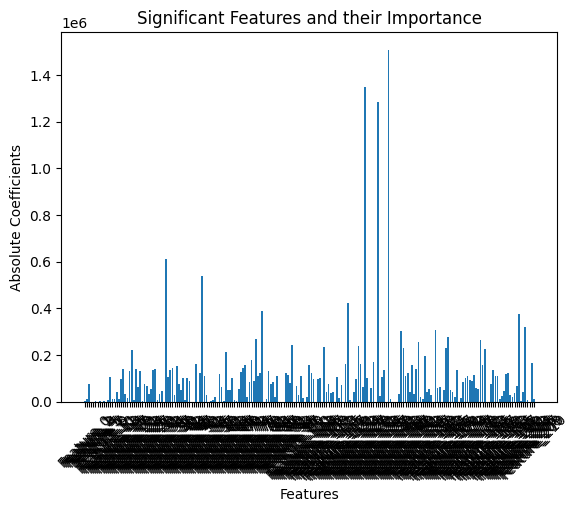


Evaluating for target: external_clicks
R-squared (Train): 0.253
R-squared (Test): 0.314
Feature: Feature_0, Score: 145.13808
Feature: Feature_1, Score: 2799.91520
Feature: Feature_2, Score: 4323.02767
Feature: Feature_3, Score: 4.69780
Feature: Feature_4, Score: 1.88670
Feature: Feature_5, Score: 344.06571
Feature: Feature_6, Score: 91.63596
Feature: Feature_7, Score: 230.76202
Feature: Feature_8, Score: 52.83768
Feature: Feature_9, Score: 237.84766
Feature: Feature_10, Score: 13.57803
Feature: Feature_11, Score: 770.19356
Feature: Feature_12, Score: 5958.04747
Feature: Feature_13, Score: 451.75482
Feature: Feature_14, Score: 736.20888
Feature: Feature_15, Score: 5106.34415
Feature: Feature_16, Score: 325.79552
Feature: Feature_17, Score: 5928.19034
Feature: Feature_18, Score: 6775.15967
Feature: Feature_19, Score: 1113.78830
Feature: Feature_20, Score: 1441.56315
Feature: Feature_21, Score: 7431.06957
Feature: Feature_22, Score: 15946.49541
Feature: Feature_23, Score: 972.21120
Featu

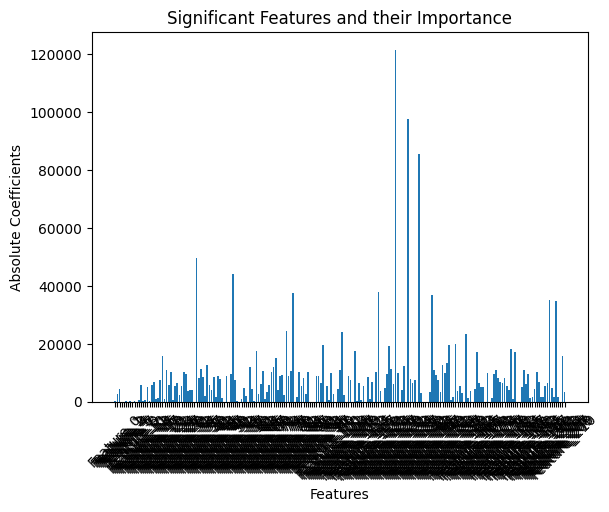


Evaluating for target: ctr
R-squared (Train): 0.186
R-squared (Test): 0.016
Feature: Feature_0, Score: 0.03253
Feature: Feature_1, Score: 0.52621
Feature: Feature_2, Score: 0.69251
Feature: Feature_3, Score: 0.00030
Feature: Feature_4, Score: 0.00224
Feature: Feature_5, Score: 0.00339
Feature: Feature_6, Score: 0.00564
Feature: Feature_7, Score: 0.00872
Feature: Feature_8, Score: 0.01628
Feature: Feature_9, Score: 0.03981
Feature: Feature_10, Score: 0.00241
Feature: Feature_11, Score: 0.04621
Feature: Feature_12, Score: 1.20240
Feature: Feature_13, Score: 0.03657
Feature: Feature_14, Score: 0.16301
Feature: Feature_15, Score: 1.88804
Feature: Feature_16, Score: 0.51295
Feature: Feature_17, Score: 0.17812
Feature: Feature_18, Score: 0.38026
Feature: Feature_19, Score: 0.68942
Feature: Feature_20, Score: 1.91471
Feature: Feature_21, Score: 0.53470
Feature: Feature_22, Score: 0.88507
Feature: Feature_23, Score: 0.12119
Feature: Feature_24, Score: 1.96759
Feature: Feature_25, Score: 0.562

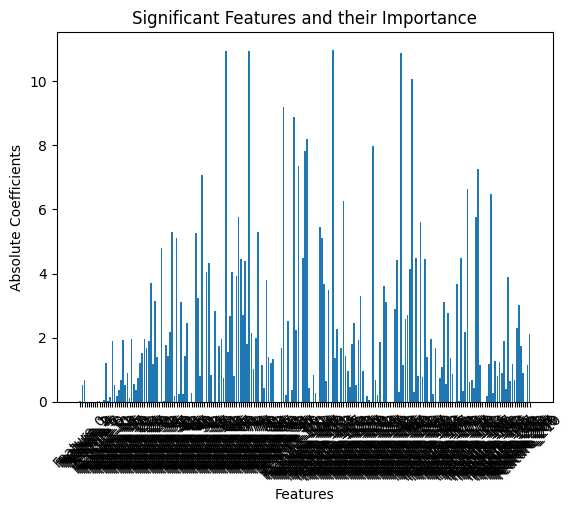

In [46]:
target = ['external_impressions', 'external_clicks', 'ctr']

columns = ['no_versions','n_days','classification_product','scraped_author',
           'likes_n_days','dislikes_n_days','scraped_word_count','media_type','meta_title_len','meta_desc_len','h1_len','abstract_len']

X = {#"Length related features" : "df_enc[['word_count','meta_title_len', 'meta_desc_len', 'h1_len', 'abstract_len']]",
    "All features": "df_enc",
    #"Performance metrics" : "df_enc[['likes_n_days','dislikes_n_days']]",
    #"EDA identified features": "pd.concat([media_col, author_col, product_col, df_news['n_days']], axis=1)"
    }

for key, value in X.items():
    print(f"================ {key} ================")
    features = eval(value) 
    for item in target:
        y = df_news[item]
        print(f"Evaluating for target: {item}")
        lin_reg_evaluation(features, y)
        print()

In [ ]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()